# Diffusion Network

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm.auto import trange, tqdm

2024-10-24 18:23:32.472484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 18:23:32.472734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 18:23:32.499479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 18:23:32.591496: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 18:23:33.499747: W tensorflow/compiler/tf2

## Loading data

In [2]:
# Loading Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalization to [-1, 1]
X_train = (X_train / 127.5) - 1.0

# Adding a dimension that represents the channel
X_train = np.expand_dims(X_train, axis=-1)

## Applying noise

In [3]:
IMG_SIZE = 28     # Size of the input images, Fashion MNIST is 28x28
BATCH_SIZE = 128  # Batch size for training
timesteps = 16    # Number of iterations required to denoise an image
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # time bar to check progress

In [4]:
def min_max_image_normalization(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

In [5]:
def show_examples(x):
    num_images = x.shape[0]
    plt.figure(figsize=(10, 10))
    for i in range(min(25, num_images)):  # Shows only 25 examples
        plt.subplot(5, 5, i+1)
        img = min_max_image_normalization(x[i])
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')

In [6]:
def forward_noise(img, t):
    # Each time step represents a level of noise
    t_a = time_bar[t]      # represents level of noise in current time
    t_b = time_bar[t + 1]  # represents level of noise in the next step time
    
    noise = np.random.normal(size=img.shape)  # Generate noise
    t_a = t_a.reshape((-1, 1, 1, 1))
    t_b = t_b.reshape((-1, 1, 1, 1))
    img_a = img * (1 - t_a) + noise * t_a # adding noise in t. (1-t_a) represents the proportion of noise added
    img_b = img * (1 - t_b) + noise * t_b # adding noise in t+1. (1-t_b) represents the proportion of noise added
    
    return img_a, img_b

In [7]:
# Generate random time steps
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

### Generating training examples

Each time step generated by generate_st() represents a different level of noise. The neural network will be trained to remove the noise at each step.

In [8]:
# Generate 3 training examples
t = generate_ts(3) 
a, b = forward_noise(X_train[:3], t)

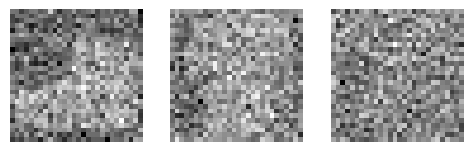

In [9]:
# In time step t
show_examples(a)

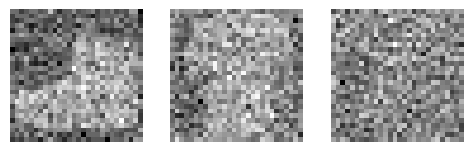

In [10]:
# In time step t+1
show_examples(b)

## U-Net Architecture

In [11]:
def conv_block(x):
    x = layers.Conv2D(128, kernel_size=3, padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [12]:
def make_model():
    # Adjusting the input for Fashion MNIST
    x = x_input = layers.Input(shape=(28, 28, 1), name='x_input')

    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    # ----- Encoding: left ( down ) -----
    x = x28 = conv_block(x)  # 28x28 -> 28x28
    x = layers.MaxPool2D(2, padding='same')(x)  # 28x28 -> 14x14

    x = x14 = conv_block(x)  # 14x14 -> 14x14
    x = layers.MaxPool2D(2, padding='same')(x)  # 14x14 -> 7x7

    x = x7 = conv_block(x)  # 7x7 -> 7x7
    x = layers.MaxPool2D(2, padding='same')(x)  # 7x7 -> 4x4

    x = x4 = conv_block(x)  # 4x4 -> 4x4

    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    # ----- Decoding: right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = conv_block(x)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)  # 4x4 -> 8x8

    # Adjust to 7x7
    x = layers.Cropping2D(((0, 1), (0, 1)))(x)  # 8x8 -> 7x7

    x = layers.Concatenate()([x, x7])
    x = conv_block(x)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)  # 7x7 -> 14x14

    x = layers.Concatenate()([x, x14])
    x = conv_block(x)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)  # 14x14 -> 28x28

    x = layers.Concatenate()([x, x28])
    x = conv_block(x)

    # ----- output -----
    x = layers.Conv2D(1, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

## Building the Diffusion Model

In [13]:
model = make_model()

2024-10-24 18:23:35.979354: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


In [14]:
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008))

In [18]:
def predict(model, timesteps=50, batch_size=32):
    # Initialize gaussian noise
    x = np.random.normal(size=(batch_size, 28, 28, 1))

    for i in trange(timesteps):
        t = np.full((batch_size, 1), i)  # Time as colum vector
        x = model.predict([x, t], verbose=0)

    # Normalization [0,1]
    x = (x - x.min()) / (x.max() - x.min())

    show_examples(x)

In [33]:
def predict_step(model, timesteps=50, num_samples=8):
    xs = []
    x = np.random.normal(size=(num_samples, 28, 28, 1))  # Adjusting for Fashion MNIST

    for i in trange(timesteps):
        t = np.full((num_samples, 1), i)  # Time as a column vector
        x = model.predict([x, t], verbose=0)
        if i % 5 == 0:  # Save at each 5 steps
            xs.append(x[0])

    # Normalization [0,1]
    xs = [(x - x.min()) / (x.max() - x.min()) for x in xs]

    plt.figure(figsize=(20, 3))
    for i, img in enumerate(xs):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(min_max_image_normalization(img), cmap='gray')
        plt.title(f'Step {i*5}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [21]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

In [29]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [30]:
train()

  0%|          | 0/50 [00:00<?, ?it/s]

2024-10-24 18:54:29.474097: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-10-24 18:54:31.640648: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa8d999d430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-24 18:54:31.640684: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-10-24 18:54:31.661679: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1729796071.794906    1791 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  0%|          | 0/50 [00:00<?, ?it/s]

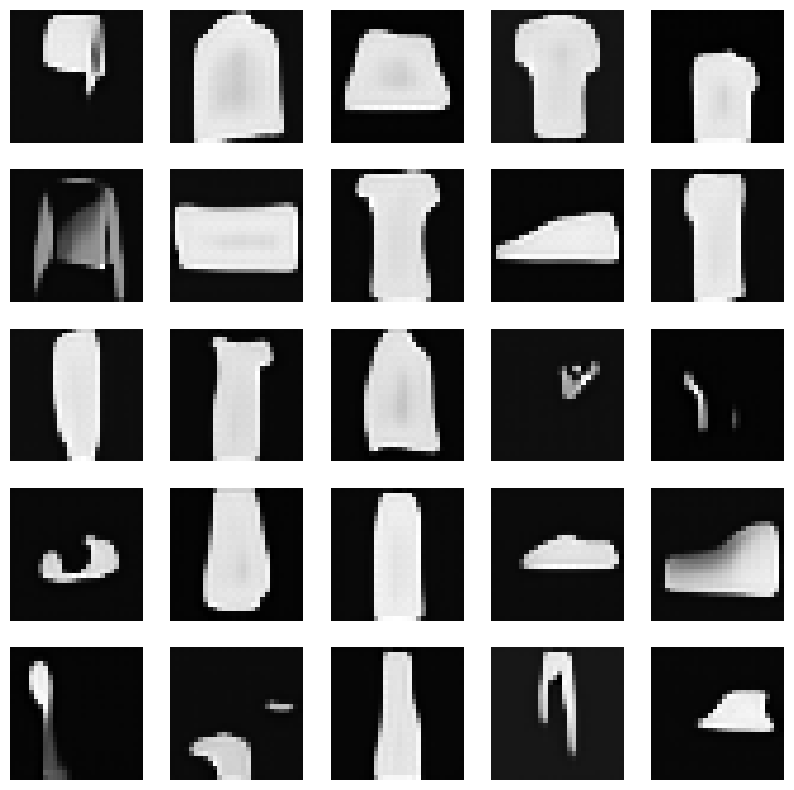

In [31]:
predict(model)

  0%|          | 0/50 [00:00<?, ?it/s]

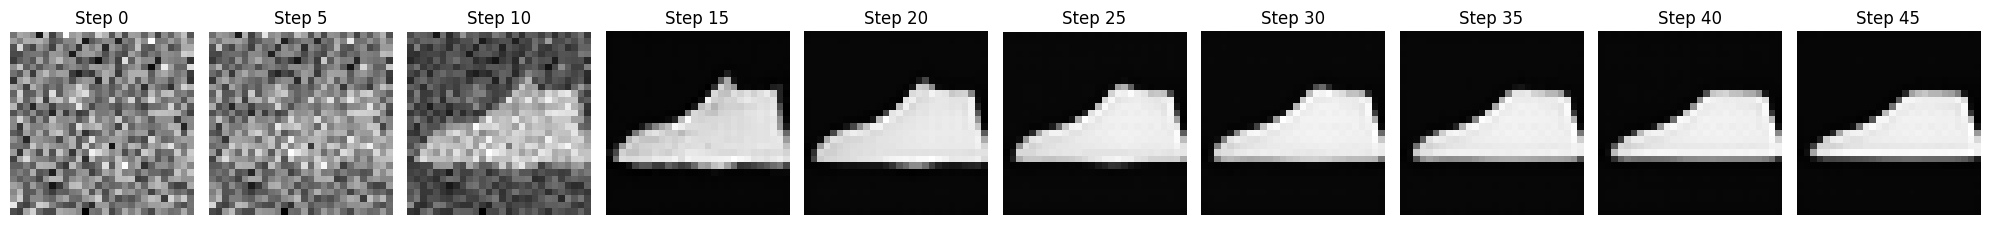

In [34]:
predict_step(model)